In [1]:
import logging
import os
import shutil
import sys
import time
import tempfile
from glob import glob
from tqdm import tqdm
import pickle

import pandas as pd
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import (
    ITKReader,
    NumpyReader,
)
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    Flipd,
    Lambdad,
    LoadImaged,
    RandAdjustContrastd, #check whether necessary
    RandFlipd,
    RandAffined,
    Resize,
    Resized,
    Rotate90d,
    ScaleIntensity,
    ScaleIntensityd,
    ToNumpy,
    ToTensor,
    ToTensord,
)
from monai.utils import first

from matplotlib import pylab as plt
from skimage.io import imread

import itk

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

MONAI version: 1.0.1
Numpy version: 1.22.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: E:\Users\BerkOlcay\anaconda3\envs\DL\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.4.1
transformers version: 4.24.0
mlflow version: 1.30.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

Device is cuda


In [10]:

def draw_segmented_area(frame_rgb, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_areas_separately(frame_rgb, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(32, 24))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots(1,4)
        fig_created = True
    ax[0].imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0)
    ax[0].axis('off')
    
    ax[1].imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0)
    ax[1].axis('off')
    
    ax[2].imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0)
    ax[2].axis('off')
    
    ax[3].imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0)
    ax[3].axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        

def draw_segmented_pupil(frame_rgb, pupil_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_iris(frame_rgb, iris_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_glints(frame_rgb, glints_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_visible(frame_rgb, visible_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()

pn_code = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\PYTHON'
pn_data = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\data\\data_dv3d_monai_QA'

df = pd.read_csv(os.path.join(pn_code,'df_dv3d_monai_files.csv'), index_col=0)
df['fn_seg_maps_np'] = [s.replace('.pkl','.pkl') for s in df.fn_seg_maps]

# set up dataset splits and dict-lists
check_idxs = np.arange(0,df.shape[0])

check_files = [{"img": os.path.join(pn_data, fn_img), "seg": os.path.join(pn_data, fn_seg)} for fn_img, fn_seg in zip(df.fn_img[check_idxs], df.fn_seg_maps_np[check_idxs])]

print(f'df.columns:\n {df.columns.tolist()}')
df.head()

df.columns:
 ['fn_img', 'fn_qa_img', 'fn_annotation', 'fn_seg_maps', 'tag_dataset', 'fn_seg_maps_np']


,fn_img,fn_qa_img,fn_annotation,fn_seg_maps,tag_dataset,fn_seg_maps_np
0,12451_ubiris2_C107_S1_I7_000000.tiff,12451_ubiris2_C107_S1_I7_000000_seg_qa.png,12451_ubiris2_C107_S1_I7_000000.txt,12451_ubiris2_C107_S1_I7_000000_seg_maps.pkl,ubiris2,12451_ubiris2_C107_S1_I7_000000_seg_maps.pkl
1,12452_ubiris2_C133_S1_I4_000000.tiff,12452_ubiris2_C133_S1_I4_000000_seg_qa.png,12452_ubiris2_C133_S1_I4_000000.txt,12452_ubiris2_C133_S1_I4_000000_seg_maps.pkl,ubiris2,12452_ubiris2_C133_S1_I4_000000_seg_maps.pkl
2,12453_ubiris2_C79_S2_I2_000000.tiff,12453_ubiris2_C79_S2_I2_000000_seg_qa.png,12453_ubiris2_C79_S2_I2_000000.txt,12453_ubiris2_C79_S2_I2_000000_seg_maps.pkl,ubiris2,12453_ubiris2_C79_S2_I2_000000_seg_maps.pkl
3,12454_ubiris2_C390_S1_I15_000000.tiff,12454_ubiris2_C390_S1_I15_000000_seg_qa.png,12454_ubiris2_C390_S1_I15_000000.txt,12454_ubiris2_C390_S1_I15_000000_seg_maps.pkl,ubiris2,12454_ubiris2_C390_S1_I15_000000_seg_maps.pkl
4,12455_ubiris2_C85_S1_I1_000000.tiff,12455_ubiris2_C85_S1_I1_000000_seg_qa.png,12455_ubiris2_C85_S1_I1_000000.txt,12455_ubiris2_C85_S1_I1_000000_seg_maps.pkl,ubiris2,12455_ubiris2_C85_S1_I1_000000_seg_maps.pkl


In [11]:
def convert_overlapping_to_one_hot():
    print ("iterating training data")
    for index, item in enumerate(check_files):
        with open( item["seg"], 'rb') as file:
            arr = pickle.load(file)
            pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, = tuple([np.squeeze(arr[c,:,:]) for c in [0,1,2,3]])
        
            # ideally this should be the operation to separate the segmentations, but there are some wrongly labeled imgs
            # visible_map_masked = visible_map_masked - iris_map_masked - glints_map_masked
            
            # I want to get relative complement (visible_map_masked\others). That is visible_map_masked intersected with not of others.
            # Formula B\A= B & !A
            # If there was not logical not in the combination, & would return the intersection with the union of others
            visible_map_masked = visible_map_masked & np.logical_not(iris_map_masked | pupil_map_masked | glints_map_masked)
            iris_map_masked = iris_map_masked & np.logical_not(pupil_map_masked | glints_map_masked)
            pupil_map_masked = pupil_map_masked & np.logical_not(glints_map_masked)

            overlap_visible_map_masked = visible_map_masked & (iris_map_masked | pupil_map_masked | glints_map_masked)
            overlap_iris_map_masked = iris_map_masked & (visible_map_masked | pupil_map_masked | glints_map_masked)
            overlap_pupils_map_masked = pupil_map_masked & (visible_map_masked | iris_map_masked | glints_map_masked)
            overlap_glint_map_masked = glints_map_masked & (visible_map_masked | iris_map_masked | pupil_map_masked)

            if (is_overlap_visible_map_masked | is_overlap_iris_map_masked | is_overlap_pupils_map_masked | is_overlap_glint_map_masked):
                overlapping_indexes.append(index)
                print(index)
                print("is_overlap_visible_map_masked? ", is_overlap_visible_map_masked)
                print("is_overlap_iris_map_masked? ", is_overlap_iris_map_masked)
                print("is_overlap_pupils_map_masked? ", is_overlap_pupils_map_masked)
                print("is_overlap_glint_map_masked? ", is_overlap_glint_map_masked)
            
            new_seg = np.array(arr)
            new_seg[0,:,:] = pupil_map_masked            
            new_seg[1,:,:] = iris_map_masked
            new_seg[2,:,:] = visible_map_masked
            new_seg[3,:,:] = glints_map_masked

            fileObject = open(check_files[index]["seg"], 'wb')
            pickle.dump(new_seg, fileObject)
            fileObject.close()

            if (index % (int(len(check_files)/5)) == 0 and index != 0):
                print("%", index/len(check_files) *100, " completed")
    print ("iterating done")
  
isConvert = False
if (isConvert):
    convert_overlapping_to_one_hot()
else:
    print("Overlapping to one hot conversion is turned off.")


Overlapping to one hot conversion is turned off.


In [12]:
# define transforms for image and segmentation
img_size = np.array([240,320])
rot_max = 45*np.pi/180.0
shear_max = 0.5
trans_max = tuple((img_size*0.15).astype(int))
scale_max = 0.25

def gray2rgb(x):
    #print(x.shape)
    if x.shape[0]==1:
        x = x.repeat(3, 1, 1)
        x.meta['original_channel_dim'] = -1 # THIS is the important line! 
    #print(x.shape)
    return x

def clean_tiff_meta(x):
    for key in ['DocumentName', 'ImageDescription', 'Software']:
        if key in x.meta.keys():
            del x.meta[key]
    return x

train_transforms = Compose(
    [
        #Lambdad(keys=['img', 'seg'], func=lambda x: print(x), overwrite = False),
        LoadImaged(keys=["img"], reader= ITKReader, image_only = True),
        LoadImaged(keys=["seg"], reader=NumpyReader, image_only = True),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=['img'], func=lambda x: gray2rgb(x)), # gray to rgb conversion
        ScaleIntensityd(keys="img"),        
        Flipd(keys=["seg"], spatial_axis=[1]), # necessary due to various readers ITKReader and NumpyReader
        Rotate90d(keys=["seg"]), # necessary due to various readers ITKReader and NumpyReader
        Rotate90d(keys=["img", "seg"]), # necessary due to various readers ITKReader and NumpyReader
        Resized(keys=["img", "seg"], spatial_size=(240,320)),
        RandAdjustContrastd(keys=["seg"], prob=1.0, gamma=(0.1, 10.0)),
        EnsureTyped(keys="img"),
        Lambdad(keys=['img'], func=lambda x: clean_tiff_meta(x)), # clean weird keys in TIFF metadata - turns out this is not necessary
        ToTensord(keys=["img", "seg"]),
    ]
)

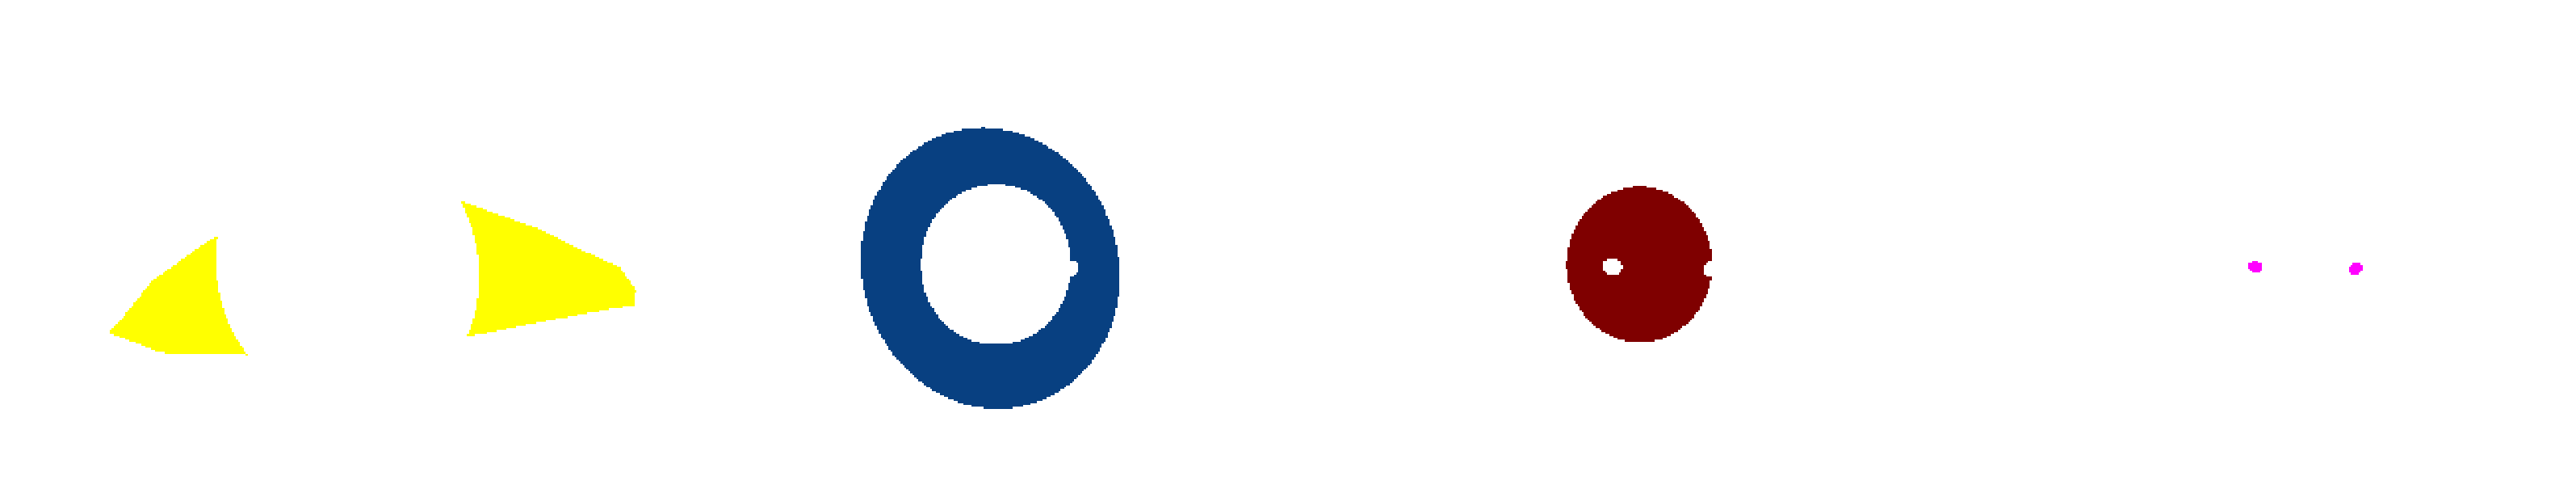

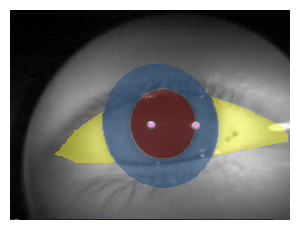

In [13]:
npc = ToNumpy()
check_ds = monai.data.Dataset(data=check_files, transform=train_transforms)
check_loader = DataLoader(
    check_ds, 
    batch_size=10, 
    shuffle=True,
    num_workers=0)
check_data = first(check_loader)
for i in range(1):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    # channel first versions
    img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
    seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
    #print("npc(check_data[seg] ", npc(check_data["seg"]).shape)
    #print("seg_cf.shape", seg_cf.shape)
    #print("seg_cf.shape", seg_cf.shape)
    #print (seg_cf)
    # channel last versions for plotting
    pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, = tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3]])
    img = np.moveaxis(img_cf, [0,1,2], [-1,-3,-2])
    draw_segmented_areas_separately(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked)
    draw_segmented_area(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked)
    #plt.imshow(img)
    #plt.show()

is_overlap_visible_map_masked?  False
is_overlap_iris_map_masked?  False
is_overlap_pupils_map_masked?  False
is_overlap_glint_map_masked?  False


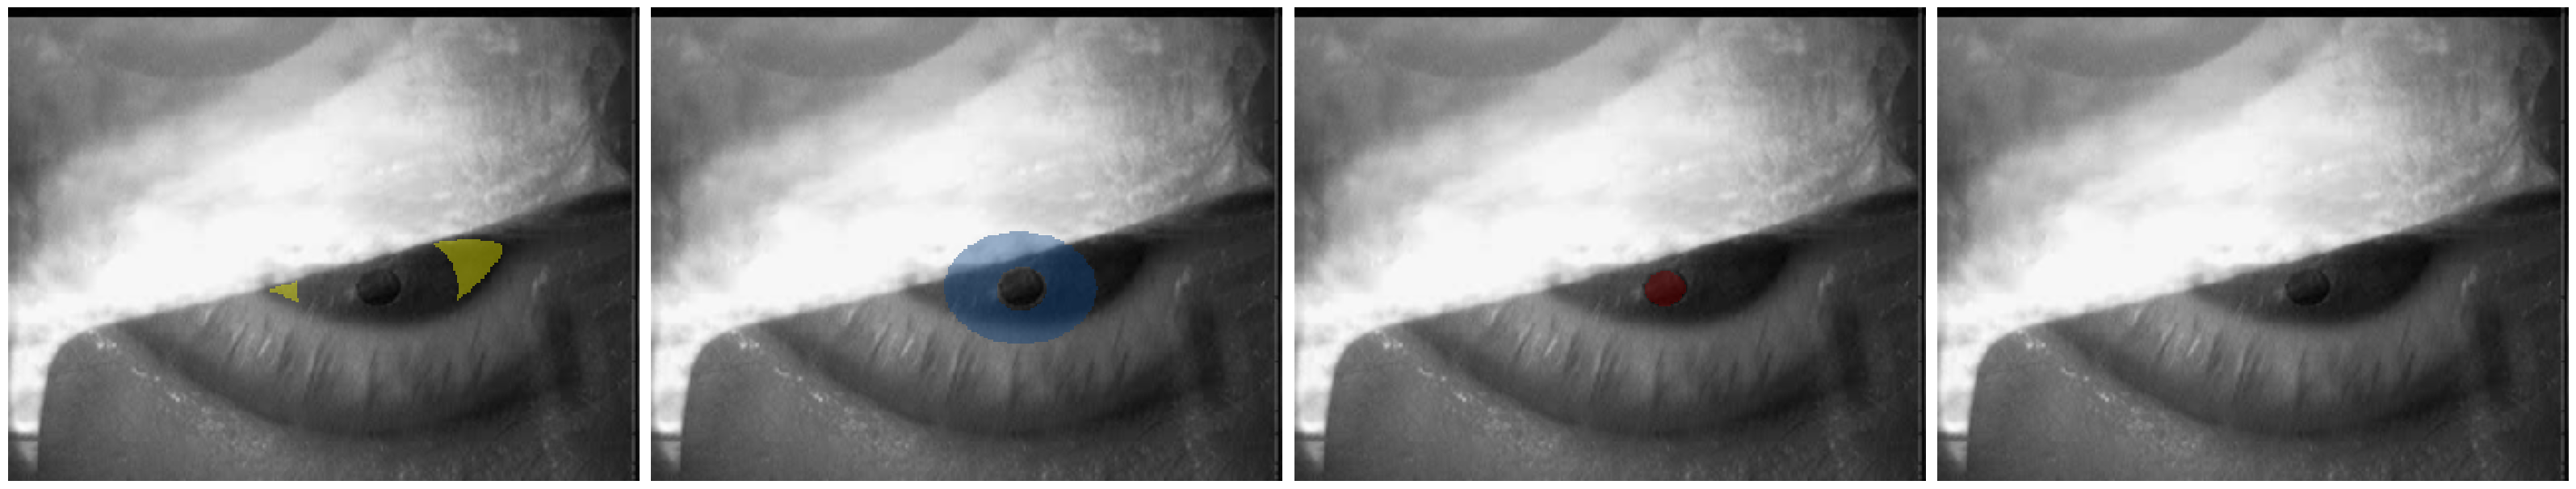

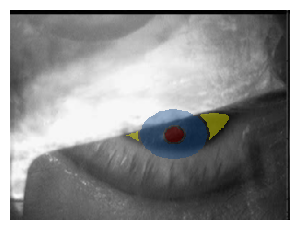

In [214]:
'''
# part to manually separate overlaping after monai transfroms
visible_map_masked = visible_map_masked - iris_map_masked- pupil_map_masked - glints_map_masked
iris_map_masked = iris_map_masked - pupil_map_masked- glints_map_masked
pupil_map_masked = pupil_map_masked - glints_map_masked

visible_map_masked = visible_map_masked.clip(min=0)
iris_map_masked = iris_map_masked.clip(min=0)
pupil_map_masked = pupil_map_masked.clip(min=0)
'''

bin_visible_map_masked = np.where(visible_map_masked > 0.5, True, False)
bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
bin_pupil_map_masked = np.where(pupil_map_masked > 0.5, True, False)
bin_glints_map_masked = np.where(glints_map_masked > 0.5, True, False)

overlap_visible_map_masked = bin_visible_map_masked & (bin_iris_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
overlap_iris_map_masked = bin_iris_map_masked & (bin_visible_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
overlap_pupils_map_masked = bin_pupil_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_glints_map_masked)
overlap_glint_map_masked = bin_glints_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_pupil_map_masked)

is_overlap_visible_map_masked = np.any(overlap_visible_map_masked)
is_overlap_iris_map_masked = np.any(overlap_iris_map_masked)
is_overlap_pupils_map_masked = np.any(overlap_pupils_map_masked)
is_overlap_glint_map_masked = np.any(overlap_glint_map_masked)

print("is_overlap_visible_map_masked? ", is_overlap_visible_map_masked)
print("is_overlap_iris_map_masked? ", is_overlap_iris_map_masked)
print("is_overlap_pupils_map_masked? ", is_overlap_pupils_map_masked)
print("is_overlap_glint_map_masked? ", is_overlap_glint_map_masked)
                                         
draw_segmented_areas_separately(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked)
draw_segmented_area(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked)


In [140]:
# iterate through overlap segmentation to check whether the process of converting one-hot works

def check_overlapping_after_one_hot_conversion():
    check_ds = monai.data.Dataset(data=check_files, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1, num_workers=0)
    overlapping_indexes = []
    print ("iterating training data")
    for index, check_data in enumerate(check_loader):
        img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
        seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
        pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, = tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3]])
        
        # ideally this should be the operation to separate the segmentations, but there are some wrongly labeled imgs
        # visible_map_masked = visible_map_masked - iris_map_masked - glints_map_masked
        visible_map_masked = visible_map_masked - iris_map_masked - pupil_map_masked - glints_map_masked
        iris_map_masked = iris_map_masked - pupil_map_masked- glints_map_masked
        pupil_map_masked = pupil_map_masked - glints_map_masked

        visible_map_masked = visible_map_masked.clip(min=0)
        iris_map_masked = iris_map_masked.clip(min=0)
        pupil_map_masked = pupil_map_masked.clip(min=0)

        bin_visible_map_masked = np.where(visible_map_masked > 0.5, True, False)
        bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
        bin_pupil_map_masked = np.where(pupil_map_masked > 0.5, True, False)
        bin_glints_map_masked = np.where(glints_map_masked > 0.5, True, False)

        overlap_visible_map_masked = bin_visible_map_masked & (bin_iris_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
        overlap_iris_map_masked = bin_iris_map_masked & (bin_visible_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
        overlap_pupils_map_masked = bin_pupil_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_glints_map_masked)
        overlap_glint_map_masked = bin_glints_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_pupil_map_masked)

        is_overlap_visible_map_masked = np.any(overlap_visible_map_masked)
        is_overlap_iris_map_masked = np.any(overlap_iris_map_masked)
        is_overlap_pupils_map_masked = np.any(overlap_pupils_map_masked)
        is_overlap_glint_map_masked = np.any(overlap_glint_map_masked)
        
        if (is_overlap_visible_map_masked | is_overlap_iris_map_masked | is_overlap_pupils_map_masked | is_overlap_glint_map_masked):
            overlapping_indexes.append(index)
            print(index)
            print("is_overlap_visible_map_masked? ", is_overlap_visible_map_masked)
            print("is_overlap_iris_map_masked? ", is_overlap_iris_map_masked)
            print("is_overlap_pupils_map_masked? ", is_overlap_pupils_map_masked)
            print("is_overlap_glint_map_masked? ", is_overlap_glint_map_masked)
            
        twenty_percent = (int(len(check_files)))
        if (index%twenty_percent == 0 and index != 0):
            print("%", index/twenty_percent *100, " completed")
    
    print ("iterating done")
    
    return overlapping_indexes
    
overlapping_indexes = check_overlapping_after_one_hot_conversion()
print(overlapping_indexes)

iterating training data
iterating done
[]


In [131]:
# Iterate through fail cases and print their size, whether it's empty. 
# There are some without segmentation, there are some with wrong segmentation/
# For example control images in [575, 873, 1811, 1910, 2116, 2130, 2636, 2705, 2719, 3145, 3403, 4195, 4418, 4619, 4811, 4849, 4899, 4970, 5067, 5247, 5272, 5328, 5441, 5476, 5491]

iris_check_files= np.take(check_files, overlapping_indexes)
check_ds = monai.data.Dataset(data=iris_check_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=0)
for index, check_data in enumerate(check_loader):
        img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
        seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
        pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, = tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3]])
        
        print("index", overlapping_indexes[index])
        print(iris_map_masked.sum())
        bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
        print(np.any(bin_iris_map_masked))
        print(bin_iris_map_masked.sum())
        print(" ")

index 575
24.99998
True
25
 
index 873
132.99995
True
133
 
index 1811
3838.9966
True
3839
 
index 1910
73.61053
True
71
 
index 2116
71.99999
True
72
 
index 2130
0.0
False
0
 
index 2636
53.999958
True
54
 
index 2705
47.99995
True
48
 
index 2719
39.999985
True
40
 
index 3145
64.99998
True
65
 
index 3403
33.57487
True
31
 
index 4195
65.999954
True
66
 
index 4418
0.0
False
0
 
index 4619
40.99998
True
41
 
index 4811
1383.9988
True
1384
 
index 4849
28662.934
True
28622
 
index 4899
78.47903
True
84
 
index 4970
69.99999
True
70
 
index 5067
199.99995
True
200
 
index 5247
63.999954
True
64
 
index 5272
0.0
False
0
 
index 5328
42.562576
True
42
 
index 5441
61.99997
True
62
 
index 5476
114.99998
True
115
 
index 5491
96.99994
True
97
 
